In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
from custom_mpl_settings import load_mpl_rc
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()
from functions import add_Teff

def get_convective_envelope_mass_fraction(x):
    if x['HELIUM_CORE_MASS_FRACTION'] == 1:
        f_conv = 0
    elif x['CONVECTIVE_ENVELOPE_MASS_TOP_FRACTION'] > 0.99:
        f_conv = x['CONVECTIVE_ENVELOPE_MASS_FRACTION']/(1-x['HELIUM_CORE_MASS_FRACTION'])
    else:
        f_conv = 0
    return f_conv

from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.MS_table_builder import MainSequenceTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.CHeB_table_builder import (
    CoreHeliumBurningTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.EAGB_table_builder import (
    EarlyAsymptoticGiantBranchTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns

evol_phase = 'EAGB'

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/{evol_phase}',
    'metallicity':0.02,
    'num_processes':4
}

if evol_phase == 'MS':
    tester = MainSequenceTableBuilder(settings=settings)
elif evol_phase == 'GB':
    tester = RedGiantBranchTableBuilder(settings=settings)
elif evol_phase == 'CHeB':
    tester = CoreHeliumBurningTableBuilder(settings=settings)
elif evol_phase == 'EAGB':
    tester = EarlyAsymptoticGiantBranchTableBuilder(settings=settings)

Building a grid with (X_0, Y_0, Z_0)=(0.7, 0.28, 0.02)


In [27]:
evol_phase = 'EAGB'
metallicity = 0.02
table_name = "tracks_Z%7.2e_%s.csv" %(float(metallicity),evol_phase)
table_filepath = os.path.join(f'/Users/natalierees/MINT_grids_23051/Z{metallicity}/{evol_phase}',table_name)
df = pd.read_csv(table_filepath,index_col=[0])
df = add_Teff(df)
df['HELIUM_CORE_MASS'] = df['HELIUM_CORE_MASS_FRACTION']*df['MASS']
df['f_conv'] = df.apply(lambda x:get_convective_envelope_mass_fraction(x),axis=1)
df['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION']  = df['HELIUM_CORE_MASS_FRACTION']

df['HYDROGEN_EXHUASTED_CORE_MASS'] = df['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION']*df['MASS']
df['CARBON_CORE_MASS'] = df['CARBON_CORE_MASS_FRACTION']*df['MASS']
df['INTERSHELL_MASS'] = df['HYDROGEN_EXHUASTED_CORE_MASS']-df['CARBON_CORE_MASS']
df['LH_div_LHe'] = df['HYDROGEN_LUMINOSITY']/df['HELIUM_LUMINOSITY']
df.reset_index(inplace=True,)
print(df.head())
df_sse = df[df['INITIAL_MASS']==df['MASS']]

   index  MASS  CENTRAL_DEGENERACY  CARBON_CORE_MASS_FRACTION   RADIUS  \
0      0  0.73               -0.25                     0.4768   0.1565   
1      0  0.73                0.25                     0.4098  37.0500   
2      0  0.73                0.25                     0.4583   2.0370   
3      0  0.73                0.25                     0.4659   0.5268   
4      0  0.73                0.25                     0.4744   0.2505   

   LUMINOSITY  LUMINOSITY_DIV_EDDINGTON_LUMINOSITY  NEUTRINO_LUMINOSITY  \
0       196.6                             0.133000                2.194   
1       379.6                             0.000949               20.850   
2       723.8                             0.243100               40.270   
3       804.4                             0.237000               44.900   
4       627.2                             0.260900               32.260   

   HYDROGEN_LUMINOSITY  HELIUM_LUMINOSITY  ...  \
0               0.9932            0.07091  ...   
1   

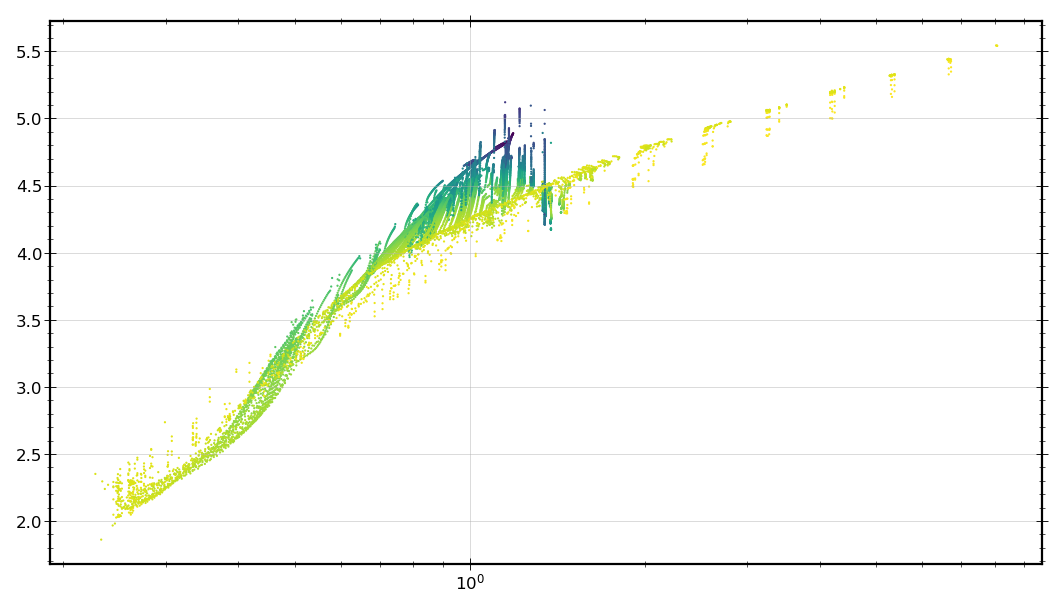

In [13]:
df_GB = df[df['f_conv']>0.4]

fig,ax=plt.subplots()

ax.scatter(df_GB['CARBON_CORE_MASS'],np.log10(df_GB['LUMINOSITY']),c=df_GB['CENTRAL_DEGENERACY'],s=1,cmap=cmap.reversed())

ax.set_xscale('log')

In [897]:
df_mass = df[df['MASS']==1.03]
transition_mass = df_mass['INITIAL_MASS'].values[df_mass['HELIUM_CORE_MASS'].argmin()]
he_flash_models = df_mass[df_mass['INITIAL_MASS']<=transition_mass]
no_he_flash_models = df_mass[df_mass['INITIAL_MASS']>=transition_mass]
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(no_he_flash_models['CENTRAL_DEGENERACY'],no_he_flash_models['HELIUM_CORE_MASS'],label='no He-flash')
ax.scatter(he_flash_models['CENTRAL_DEGENERACY'],he_flash_models['HELIUM_CORE_MASS'],label='He-flash')
ax.set_ylim(0.425,0.575)
ax.set_xlim(0,27)
ax.legend(title='$M=1.03~\mathrm{M}_\odot$',frameon=False)
ax.set(ylabel='$M_\mathrm{c}~(\mathrm{M}_\odot)$')
ax.set(xlabel='central degeneracy')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_tracks.jpeg',dpi=200)
plt.show()

In [146]:
def calc_wind_mass_loss(m):
    mass = np.log10(m.hist['star_mass'])
    radius = m.hist['log_R']
    CO = 1
    Y = 0.3

    logP = -1.12166+1.24449*mass+1.07886*radius+0.87741*mass**2-1.53239*mass*radius+0.10382*radius**2-0.07659*mass**3-0.26130*mass**2*radius+0.26867*mass*radius**2+0.03278*radius**3-0.02713*np.log10(0.02)+0.14872*Y-0.01455*np.log10(CO/0.4125541984736385)
    P = 10**(logP)

    vexp = -13.5 + 0.056*P
    vexp = np.maximum(vexp,3)
    vexp = np.minimum(vexp,15)

    Mdot1 = 10.0**(-11.4 + 0.0123*P)
    Mdot2 = 3.8E33*10**m.hist['log_L']*3.154E7/(2.9979E10*vexp*1E5*1.9885E33)
    Mdot = np.minimum(Mdot1,Mdot2)

    return Mdot

def calc_mass_with_mass_loss(m):

    Mdot = calc_wind_mass_loss(m)

    delta_t = np.diff(m.hist['star_age'])
    delta_M = delta_t*Mdot[:-1]

    M_eff = np.maximum(m.hist['star_mass'][:-1]-np.cumsum(delta_M),m.hist['he_core_mass'][:-1])
    return M_eff



fig,ax=plt.subplots(2,1,figsize=(8,12),sharex=True)

m.loadHistory('/Users/natalierees/MINT_grids_23051/Z0.02/EAGB/0.93/LOGS_EAGB_3.72')
ax[0].plot(m.hist['star_age']/1e6,m.hist['he_core_mass'],label='stripped, $M=0.93~\mathrm{M}_\odot$')
ax[1].plot(m.hist['star_age']/1e6,m.hist['log_LH']-m.hist['log_LHe'],label='stripped, $M=0.93~\mathrm{M}_\odot$')
Mdot = calc_wind_mass_loss(m)
M_eff = calc_mass_with_mass_loss(m)
AGB_termination = np.where(M_eff-m.hist['he_core_mass'][:-1]<0.0001)[0][0]
ax[0].scatter(m.hist['star_age'][AGB_termination]/1e6,m.hist['he_core_mass'][AGB_termination],label='envelope lost via wind',marker = '*',s=100)
ax[1].scatter(m.hist['star_age'][AGB_termination]/1e6,(m.hist['log_LH']-m.hist['log_LHe'])[AGB_termination],marker='*',s=100)

m.loadHistory('/Users/natalierees/MINT_grids_23051/Z0.02/EAGB/4.2/LOGS_EAGB_4.2')
ax[0].plot(m.hist['star_age']/1e6,m.hist['he_core_mass'],label='CME, $M=4.2~\mathrm{M}_\odot$')
ax[1].plot(m.hist['star_age']/1e6,m.hist['log_LH']-m.hist['log_LHe'],label='CME, $M=4.2~\mathrm{M}_\odot$')
fig.tight_layout()

m.loadHistory('/Users/natalierees/MINT_grids_23051/Z0.02/EAGB/4.74/LOGS_EAGB_4.74')
ax[0].plot(m.hist['star_age']/1e6,m.hist['he_core_mass'],label='CME, $M=4.74~\mathrm{M}_\odot$')
ax[1].plot(m.hist['star_age']/1e6,m.hist['log_LH']-m.hist['log_LHe'],label='CME, $M=4.74~\mathrm{M}_\odot$')

ax[0].legend(title = 'a)',frameon=False)
ax[1].legend(title = 'b)',frameon=False)
ax[0].set(ylabel='$M_\mathrm{c}~(\mathrm{M}_\odot)$')
ax[1].set(ylabel='$\log(L_\mathrm{H}/L_\mathrm{He})$')
ax[1].set(xlabel='Time (Myr)')
fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_stripped_vs_CME.jpeg',dpi=200)
plt.show()

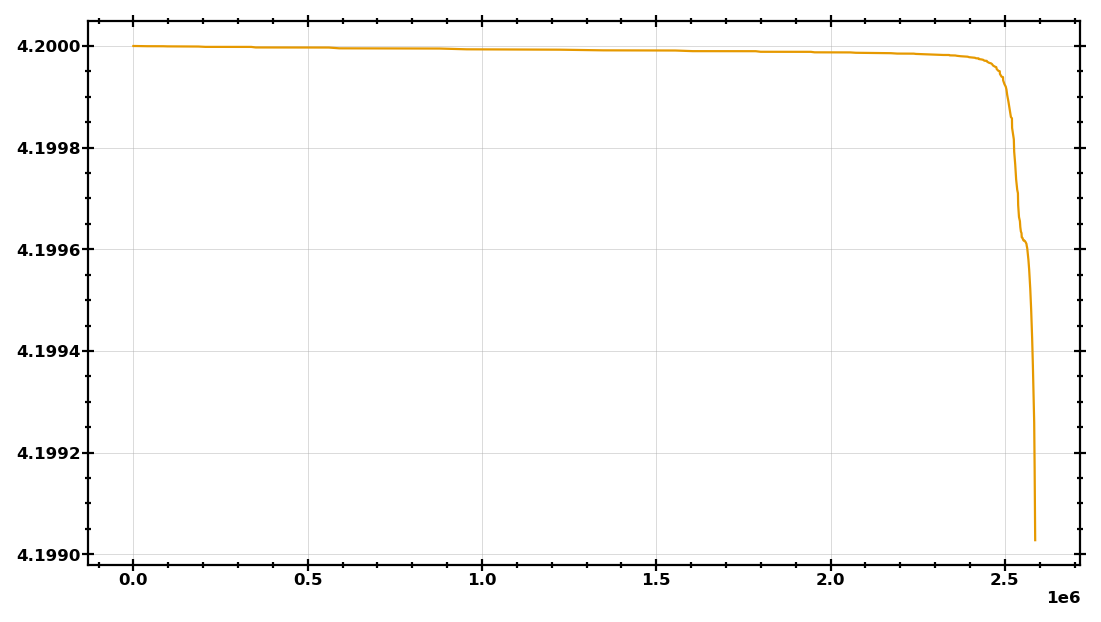

In [148]:
m.loadHistory('/Users/natalierees/MINT_grids_23051/Z0.02/EAGB/4.2/LOGS_EAGB_4.2')
M_eff = calc_mass_with_mass_loss(m)
plt.plot(m.hist['star_age'][:-1],M_eff)

In [839]:
df_sse_sdu = df_sse[(df_sse['MASS']<7)&(df_sse['MASS']>5)]
track = df[(df['MASS']==0.93)&(df['INITIAL_MASS']==3.72)]

fig,ax=plt.subplots(figsize=(8,8))

ax.scatter(df_sse_sdu['CENTRAL_DEGENERACY'],(df_sse_sdu['HYDROGEN_EXHUASTED_CORE_MASS']),label='CME of $M$ = 5.35, 6.04 and 6.83$~\mathrm{M}_\odot$')
ax.scatter(track['CENTRAL_DEGENERACY'],(track['HYDROGEN_EXHUASTED_CORE_MASS']),label='$M_\mathrm{i} = 5.35$ stripped to $M=1.63~\mathrm{M}_\odot$\n')
ax.legend(frameon=False)
ax.set(xlabel='center degeneracy')
ax.set(ylabel='$M_\mathrm{c}~(\mathrm{M}_\odot)$')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_stripped_vs_CME.jpeg',dpi=200)
plt.show()

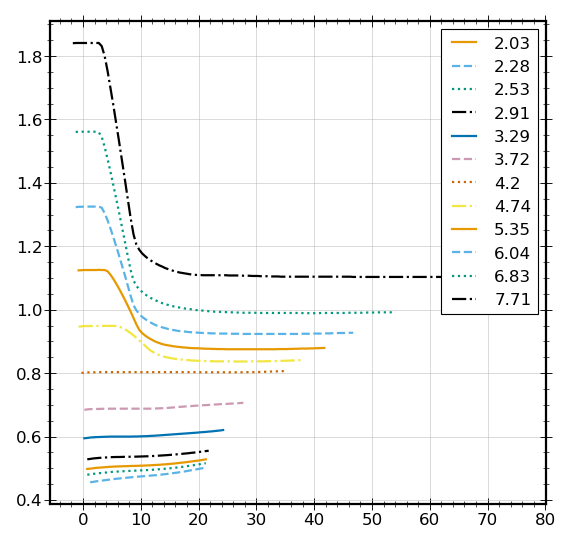

In [822]:
df_sse_sdu = df_sse[(df_sse['MASS']<8)&(df_sse['MASS']>2)]
fig,ax=plt.subplots(figsize=(8,8))
for M in df_sse_sdu['MASS'].unique():
    df_mass = df_sse_sdu[df_sse_sdu['MASS']==M]
    ax.plot(df_mass['CENTRAL_DEGENERACY'],df_mass['HYDROGEN_EXHUASTED_CORE_MASS'],label=M)
ax.legend()
# plt.ylim(0.5,3)


/Users/natalierees/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


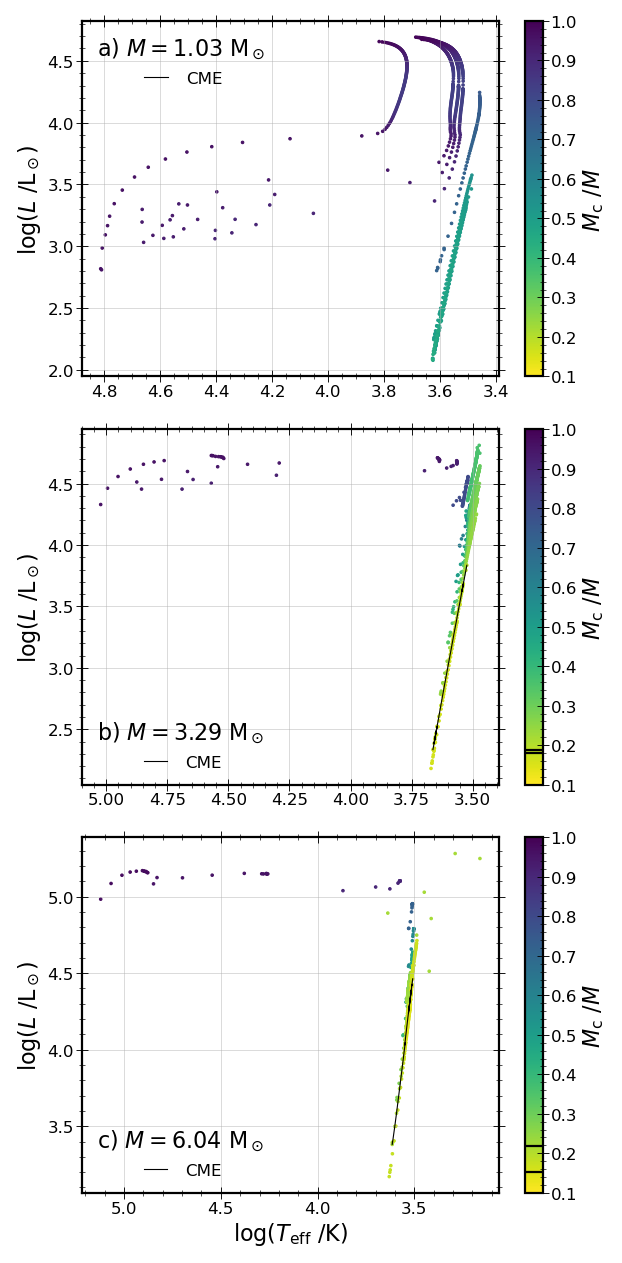

In [893]:
masses = [1.03,3.29,6.04]
fig,ax=plt.subplots(3,1,figsize=(8,16),sharex=False,sharey=False)
axs = ax.flatten()
labels = ['a','b','c']

for i, mass in enumerate(masses):
    
    df_mass = df[df['MASS']==mass]
    sc = axs[i].scatter(np.log10(df_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_mass['LUMINOSITY']),c=df_mass['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION'],s=5,cmap=cmap.reversed(),vmin=0.1,vmax=1)

    df_sse_mass = df_sse[df_sse['MASS']==mass]
    axs[i].plot(np.log10(df_sse_mass['EFFECTIVE_TEMPERATURE']),np.log10(df_sse_mass['LUMINOSITY']),c='black',ls='-',label='CME',linewidth=1)

    axs[i].legend(title=f'{labels[i]}) $M={mass}$'+'$~\mathrm{M}_\odot$',frameon=False)

    cbar = plt.colorbar(sc,ax=axs[i],location='right',label='$M_\mathrm{c}~/M$')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].min(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')
    cbar.ax.hlines(df_sse_mass['HELIUM_CORE_MASS_FRACTION'].max(), 0, 1, colors = 'black', linewidth = 2, linestyles = '-')

    axs[i].invert_xaxis()
    axs[i].set(ylabel='$\log (L~/\mathrm{L}_\odot)$')

ax[-1].set(xlabel='$\log (T_\mathrm{eff}~/\mathrm{K})$')

fig.tight_layout()
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_HR.jpeg',dpi=200)
plt.show()

In [370]:
def get_carbon_igntion(x):
    if x['CENTRAL_CARBON'].min()<x['CENTRAL_CARBON'].max()-0.05:
        return 1
    else:
        return 0

carbon_ignition = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: get_carbon_igntion(x))
TACHeB_Mc = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS'].first()
TACHeB_Mc_div_M = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].first()


min_TACHeB_Mc_for_carbon_ignition = TACHeB_Mc[carbon_ignition==1].min()
print(min_TACHeB_Mc_for_carbon_ignition)
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(np.log10(TACHeB_Mc),TACHeB_Mc_div_M,c =carbon_ignition)
ax.vlines(np.log10(min_TACHeB_Mc_for_carbon_ignition),ymin=0,ymax=1,color='black',ls='--',label='$M_\mathrm{c,TACHeB}='+f'{min_TACHeB_Mc_for_carbon_ignition}'+'$~\mathrm{M}_\odot$')
ax.set_xlim(-0.5,1)


1.8954109999999997


(-0.5, 1.0)

In [752]:
df_TPAGB = pd.DataFrame(columns = ['Mc','Mint','Mc_frac'])


2.459664


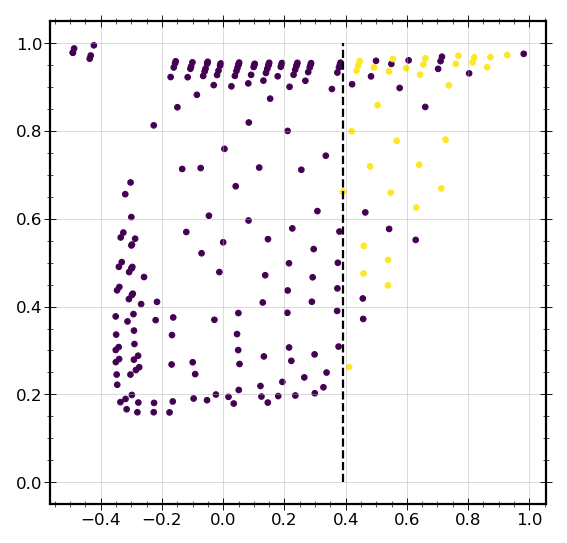

In [367]:
def get_neon_igntion(x):
    # carbon_burnt = np.where(x['CENTRAL_CARBON']<0.1)[0]
    # if x['CENTRAL_NEON'][carbon_burnt].min()<x['CENTRAL_NEON'].max()-0.05:
    if x['CENTRAL_CARBON'].min()<0.00001:
        return 1
    else:
        return 0

neon_ignition = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: get_neon_igntion(x))
TACHeB_Mc = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS'].first()
TACHeB_Mc_div_M = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS_FRACTION'].first()

min_TACHeB_Mc_for_neon_ignition = TACHeB_Mc[neon_ignition==1].min()
print(min_TACHeB_Mc_for_neon_ignition)
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(np.log10(TACHeB_Mc),TACHeB_Mc_div_M,c =neon_ignition)
ax.vlines(np.log10(min_TACHeB_Mc_for_neon_ignition),ymin=0,ymax=1,color='black',ls='--',label='$M_\mathrm{c,TACHeB}='+f'{min_TACHeB_Mc_for_neon_ignition}'+'$~\mathrm{M}_\odot$')
# ax.set_xlim(-0.5,1)

2.163294

In [894]:
### SECOND DREDGE-UP ###
def get_second_dredgeup_efficiency(x):
    DUP_bottom_index = x['HELIUM_CORE_MASS'].argmin()
    if (DUP_bottom_index!=0) and (x['HELIUM_CORE_MASS'].min()<1.4):
        # print(x['MASS'].unique(),x['INITIAL_MASS'].unique(),'2DUP')
        core_mass_during_DUP = x.iloc[:DUP_bottom_index]['HELIUM_CORE_MASS']
        return core_mass_during_DUP.max()-core_mass_during_DUP.min()
    else:
        return 0

df = df[df['MASS']<10]

second_DUP_efficiency = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: get_second_dredgeup_efficiency(x))
TACHeB_Mc = df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS'].first()
Mc_div_M = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION'].last()

fig,ax=plt.subplots(figsize=(8,10))
# sc=ax.scatter(TACHeB_Mc,second_DUP_efficiency,c=TACHeB_Mc.index.get_level_values('MASS'))
sc=ax.scatter(TACHeB_Mc,second_DUP_efficiency,c=Mc_div_M)
ax.set(xlabel='$M_\mathrm{c,TACHeB}~(\mathrm{M}_\odot)$')
ax.set(ylabel='$\Delta M_\mathrm{SDU}~(\mathrm{M}_\odot)$')
ax.set_xlim(0,3)
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M_\mathrm{c}/M$')
ax.vlines(min_TACHeB_Mc_for_carbon_ignition,ymin=0,ymax=1.1,color='black',ls='--',label='carbon ignition')
ax.vlines(min_TACHeB_Mc_for_neon_ignition,ymin=0,ymax=1.1,color='black',ls=':',label='neon ignition')
ax.legend(frameon=False)
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_2DUP.jpeg',dpi=200)
plt.show()
print(TACHeB_Mc[second_DUP_efficiency>0].min())

0.809998


In [657]:


def plot_min_intershell_mass(df):
    min_intershell_mass = df.groupby(['MASS','INITIAL_MASS'])['INTERSHELL_MASS'].last()
    TACHeB_Mc = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS'].first()
    Mc = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS'].last()
    Mc_div_M = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION'].last()
    
    return TACHeB_Mc,np.log10(min_intershell_mass),Mc_div_M

fig,ax=plt.subplots(figsize=(8,10))
x,y,z = plot_min_intershell_mass(df)
sc = ax.scatter(x,y,c=z)
x,y,z = plot_min_intershell_mass(df_sse)
ax.plot(x,y,c='black',label='CME')
ax.set_xlim(0,3)
ax.set_ylim(-4,1)
ax.set(xlabel='$M_\mathrm{c,TACHeB}~(\mathrm{M}_\odot)$')
ax.set(ylabel='$\log(M_\mathrm{int,min}~/\mathrm{M}_\odot)$')
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M_\mathrm{c}/M$')
ax.vlines(min_TACHeB_Mc_for_carbon_ignition,ymin=-4,ymax=1,color='black',ls='--',label='carbon ignition')
ax.vlines(min_TACHeB_Mc_for_neon_ignition,ymin=-4,ymax=1,color='black',ls=':',label='neon ignition')
ax.legend(frameon=False,loc='upper left')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_Mint.jpeg',dpi=200)
plt.show()


/Users/natalierees/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [491]:
def plot_min_intershell_mass(df):
    min_intershell_mass = df.groupby(['MASS','INITIAL_MASS'])['INTERSHELL_MASS'].last()
    Mc = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS'].last()
    Mc_div_M = df.groupby(['MASS','INITIAL_MASS'])['HYDROGEN_EXHUASTED_CORE_MASS_FRACTION'].last()
    
    return Mc,np.log10(min_intershell_mass),Mc_div_M

fig,ax=plt.subplots(figsize=(8,10))
x,y,z = plot_min_intershell_mass(df)
sc = ax.scatter(x,y,c=z)
x,y,z = plot_min_intershell_mass(df_sse)
ax.plot(x,y,c='black',label='CME')
ax.set_xlim(0,1.5)
ax.set_ylim(-4,1)
ax.set(xlabel='$M_\mathrm{c}~(\mathrm{M}_\odot)$')
ax.set(ylabel='$\log(M_\mathrm{int,min}~/\mathrm{M}_\odot)$')
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M_\mathrm{c}/M$')
ax.legend(frameon=False,loc='upper left')
plt.savefig(f'plots/Z{metallicity}_{evol_phase}_Mint_vs_Mc.jpeg',dpi=200)
plt.show()


/Users/natalierees/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


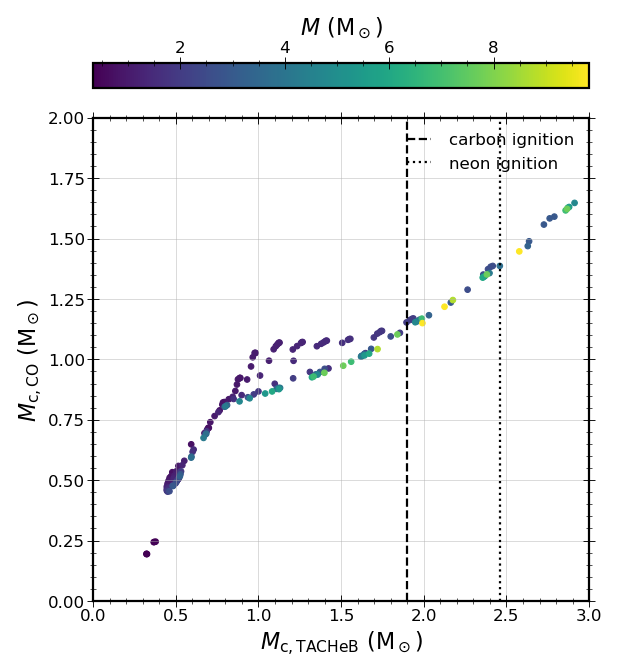

In [375]:
df['CARBON_CORE_MASS'] = df['CARBON_CORE_MASS_FRACTION']*df['MASS']
co_Mc = df.groupby(['MASS','INITIAL_MASS'])['CARBON_CORE_MASS'].max()

fig,ax=plt.subplots(figsize=(8,10))
sc=ax.scatter(TACHeB_Mc,co_Mc,c=TACHeB_Mc.index.get_level_values('MASS'))
ax.set(xlabel='$M_\mathrm{c,TACHeB}~(\mathrm{M}_\odot)$')
ax.set(ylabel='$M_\mathrm{c,CO}~(\mathrm{M}_\odot)$')
ax.set_ylim(0,2)
ax.set_xlim(0,3)
cbar = plt.colorbar(sc,ax=ax,location='top',label='$M~(\mathrm{M}_\odot)$')
ax.vlines(min_TACHeB_Mc_for_carbon_ignition,ymin=0,ymax=2,color='black',ls='--',label='carbon ignition')
ax.vlines(min_TACHeB_Mc_for_neon_ignition,ymin=0,ymax=2,color='black',ls=':',label='neon ignition')
ax.legend(frameon=False)
# plt.savefig(f'plots/Z{metallicity}_{evol_phase}_2DUP.jpeg',dpi=200)
plt.show()

In [390]:
core_carbon =  df.groupby(['MASS','INITIAL_MASS'])['CENTRAL_CARBON'].last()
TACHeB_Mc =  df.groupby(['MASS','INITIAL_MASS'])['HELIUM_CORE_MASS'].first()

fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(TACHeB_Mc,np.log10(core_carbon),c=TACHeB_Mc.index.get_level_values('MASS'))
ax.set_xlim(0,4)
ax.set_ylim(-5,0)

(-5.0, 0.0)